In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Hamaus+14 universal profile of the void : https://arxiv.org/pdf/1403.5499.pdf

In [47]:
def prof(r, dc, rs, rv, alpha, beta):
    return dc*(1-(r/rs)**alpha)/(1+(r/rv)**beta)

Consider the typical void having void radius rv=4. We will track the profile to ~3rv. Other profile parameters are taken from Hamaus et al. 2014, e.g. Fig. 2

In [141]:
dc = -0.8
rs  = 2.0
rv =  4.0
alpha = 1.5
beta = 7.0
p = np.empty(5)
p[0]=dc
p[1]=rs
p[2]=rv
p[3]=alpha
p[4]=beta

r = np.linspace(0,15,100)

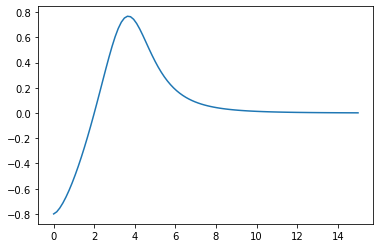

In [142]:
plt.plot(r, prof(r, *p), "C0-")
plt.show()

Prepare the grid point in 3D space. Note that the 8 quadrants are treated as independent region and the grid is prepared only for the first quadrant.

In [52]:
grid = np.linspace(0,r[-1]/np.sqrt(3.),4)
print (grid)

[0.         2.88675135 5.77350269 8.66025404]


In [54]:
mesh = np.array(np.meshgrid(grid,grid,grid, indexing="ij"))
rmesh = np.sqrt(np.sum(mesh**2, axis=0))



Make a stacked void data over Nstack voids. Furthermore, the void profile is stacked within the void to the first quadrant, which makes the profile 8 times Nstack stacking.



In [302]:
delta = None
Nstack = 10
for ip in range(8*Nstack):

    delta_ = np.random.normal(loc=prof(rmesh, dc, rs, rv, alpha, beta), scale=0.1*np.sqrt(8))
    
    if delta is None:
        delta  = delta_.flatten()[np.newaxis,:]
    else:
        delta = np.append(delta, delta_.flatten()[np.newaxis,:],axis=0)

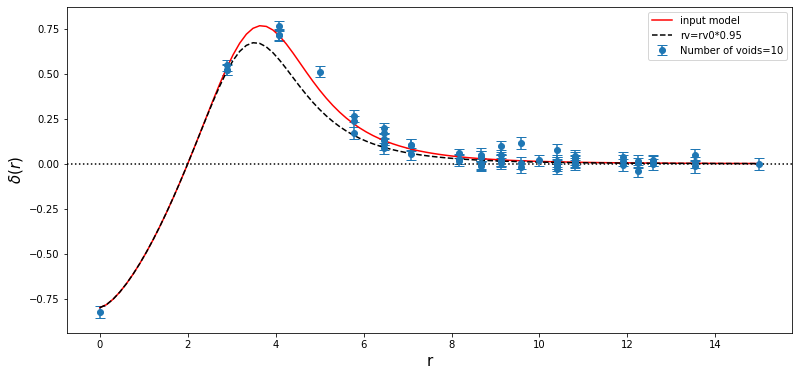

In [303]:
n = delta.shape[0]
plt.figure(figsize=(13,6))
label="Number of voids=%i"%Nstack
plt.errorbar(rmesh.flatten(), np.mean(delta,axis=0), np.std(delta,axis=0)/np.sqrt(n), ls="none", marker="o", capsize=5, label=label)
plt.plot(r, prof(r, *p), "r-", label="input model")
p1 = p*np.array([1.0, 1.0, 0.95, 1.0, 1.0])
plt.plot(r, prof(r, *p1), "k--", label="rv=rv0*0.95")
plt.axhline(y=0, ls=":", color="k")
plt.xlabel("r", fontsize=15)
plt.ylabel(r"$\delta(r)$", fontsize=15)
plt.legend()
plt.show()

Well, it seems that the r_v=r_v*0.9 model can be well constrained by the 10 stacked voids.  
Note that the errorbars represent the uncertainty of the mean, averaged over Nstack*8 samples.  


Allright, Let's move on to the Likelihood analysis.

In [304]:
cov = np.cov(delta.T)
corr = cov.copy()
for i1 in range(cov.shape[0]):
    for i2 in range(cov.shape[1]):
        corr[i1,i2] = cov[i1,i2]/np.sqrt(cov[i1,i1]*cov[i2,i2])

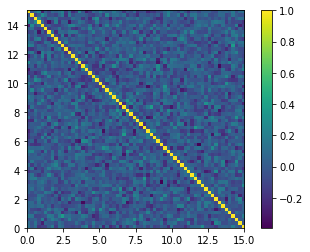

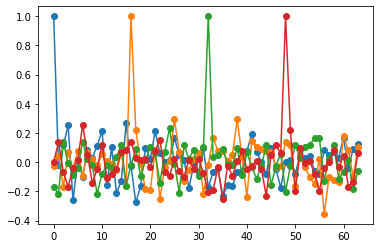

In [305]:
plt.imshow(corr.T, extent=[rmesh.min(), rmesh.max(), rmesh.min(), rmesh.max()])
plt.colorbar()
plt.show()
#
for i in range(0,corr.shape[0], 16):
    plt.plot(corr[i], "C%io-"%(int(i/16)))
plt.show()

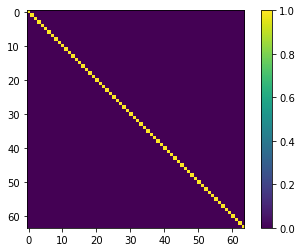

-8.040112629489893e-14
inversion success


In [306]:
invcov = np.linalg.inv(cov)

# check the matrix inversion
test = np.dot(invcov, cov)
plt.imshow(test.T)
plt.colorbar()
plt.show()
check = np.sum(test-np.identity(test.shape[0]))
print (check)

if ( np.abs(check) < 1e-10 ):
    print ("inversion success")
else:
    print ("covariance may be noisy and try to SVD")
    u, s, v = np.linalg.svd(cov)
    plt.plot(s, "C0o-")
    plt.yscale("log")
    plt.show()
    print (s)
    ss=s.copy()
    th = 1e-3
    ss[s>th] = 1./s[s>th]
    ss[s<=th]=0.
    sig = np.dot(v, np.dot(np.diag(ss), u))
    test2 = np.dot(sig, cov)
    plt.imshow(test2.T)
    plt.colorbar()
    plt.show()

    invcov = sig

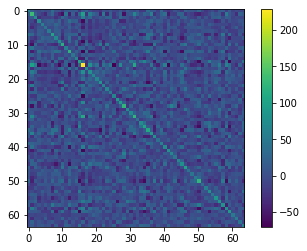

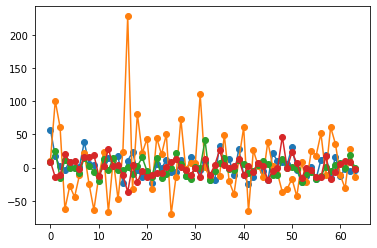

In [307]:
plt.imshow(invcov.T)
plt.colorbar()
plt.show()
#
for i in range(0,corr.shape[0], 16):
    plt.plot(invcov[i], "C%io-"%(int(i/16)))
plt.show()

2 Sigma=3.85, 4.18
1 Sigma=3.95, 4.11


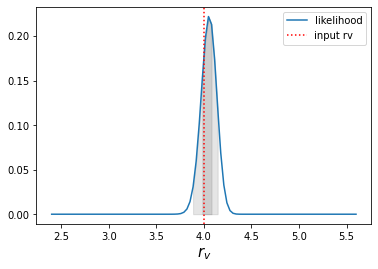

In [308]:
def nSigmaPercentile(x, likelihood, n=1):
    c = np.cumsum(likelihood)
    c /= c[-1]
    if (n==1):
        x0 = x[np.where(c<0.16)][-1]
        x1 = x[np.where(c<0.84)][-1]
    elif (n==2):
        x0 = x[np.where(c<0.025)][-1]
        x1 = x[np.where(c<0.975)][-1]
    elif (n==3):
        x0 = x[np.where(c<0.005)][-1]
        x1 = x[np.where(c<0.995)][-1]
    else:
        print ("invalid confidence band")
        return None
    return x0, x1

def loglike(x, y, p, invcov):
    dx = prof(x, *p) - y
    return -0.5* np.dot(dx.T, np.dot(invcov, dx))

ll = []
px = np.linspace(0.6,1.4, 100)
for x in px:
    p1 = p*np.array([1,1,x,1,1])
    ll.append(loglike(rmesh.flatten(), np.mean(delta, axis=0).flatten(), p1, invcov))
    
ll = np.array(ll)
x = px*p[2]
plt.plot(x, np.exp(ll), "C0-", label="likelihood")
plt.axvline(x=p[2], ls=":", color="r", label="input rv")

CLlow, CLhigh = nSigmaPercentile(x, np.exp(ll), n=2)
plt.fill_between(x, np.exp(ll), where=(x>CLlow)&(x<CLhigh), color="k", alpha=0.1)
print("2 Sigma=%.2f, %.2f"%(CLlow, CLhigh))
CLlow, CLhigh = nSigmaPercentile(x, np.exp(ll), n=1)
plt.fill_between(x, np.exp(ll), where=(x>CLlow)&(x<CLhigh), color="k", alpha=0.1)
print("1 Sigma=%.2f, %.2f"%(CLlow, CLhigh))

plt.legend()
plt.xlabel(r"$r_v$", fontsize=15)
plt.show()

Again, plot the real profiles,

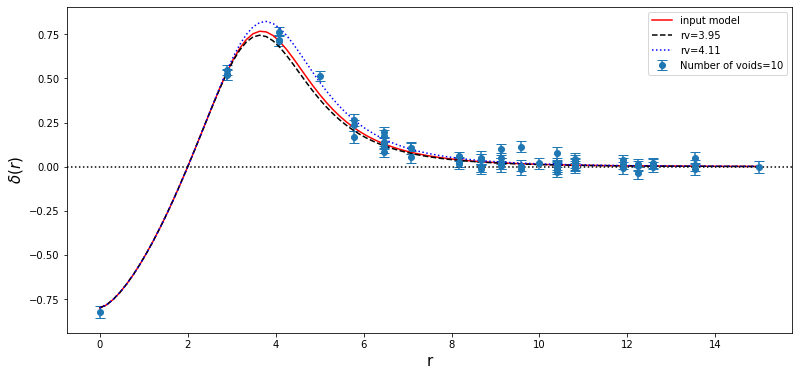

In [309]:
plt.figure(figsize=(13,6))
label="Number of voids=%i"%Nstack
plt.errorbar(rmesh.flatten(), np.mean(delta,axis=0), np.std(delta,axis=0)/np.sqrt(n), ls="none", marker="o", capsize=5, label=label)
plt.plot(r, prof(r, *p), "r-", label="input model")
p1 = p.copy()
p1[2] = CLlow
plt.plot(r, prof(r, *p1), "k--", label="rv=%.2f"%CLlow)
p1[2] = CLhigh
plt.plot(r, prof(r, *p1), "b:", label="rv=%.2f"%CLhigh)
plt.axhline(y=0, ls=":", color="k")
plt.xlabel("r", fontsize=15)
plt.ylabel(r"$\delta(r)$", fontsize=15)
plt.legend()
plt.show()